In [3]:
#Bring in our imports
import numpy as np

from scipy.optimize import minimize

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 15})

import emcee
import corner

from IPython.display import display, Math

# Now It's Your Turn

Stellar spectra are bulit upon that of a blackbody, though stars are not perfect blackbodies. The blackbody intensity is given by Planck's law which is:

$\large{\frac{2hc^2}{\lambda^5} \frac{1}{{exp[\frac{hc}{\lambda k_B T}]-1}}}$

where $h$ is Planck's constant, $c$ is the speed of light, $k_B$ is the Boltzmann constant, $\lambda$ is the wavelength and $T$ is the temperature.

The spectrum of a star very far away will be affected by redshift (z) with higher redshift corresponding to a further distance. Under redshift the temperature of a star will be transformed as:

$T \rightarrow \frac{T_0}{1+z}$

and the wavelength of a star will be transformed as:

$\lambda \rightarrow \lambda_0(1+z)$

where $T_0$ and $\lambda_0$ are the actual temperature and wavelengths (not the measured ones) respectively. Plugging these into the blackbody instensity equation gives:

$\large{\frac{2hc^2}{\lambda_0^5 (1+z)^5} \frac{1}{{exp[\frac{hc}{\lambda_0 k_B T_0}]-1}}}$

Coding this up looks like:

In [163]:
from astropy.constants import h, k_B, c
from astropy import units as u

def blackbody(wavelength,temperature,z):
    '''
    Blackbody intensity as a function of wavelength, temperature and redshift
    
    Inputs:
    ------
        wavelength:  array-like
                     wavelength(s) in units of Angstroms to calculate the intensities for
                        
        temperature: float
                     the actual temperature in units of Kelvin
        
        z:           float
                     the redshift z
                     
    Return:
    ------
        intensity:   array-like
                     blackbody intensity in cgs units but with angstroms for wavelength erg s^-1 cm^-2 AA^-1
    '''
    
    wave_cgs = (wavelength*u.AA).to(u.cm)
    temp_cgs = temperature*u.K
    h_cgs = h.to(u.erg*u.s) 
    c_cgs = c.to(u.cm/u.s)
    k_cgs = k_B.to(u.erg/u.K)
    
    intensity = 2*h_cgs*c_cgs**2 / (wave_cgs**5 * (1+z)**5 * (np.exp(h_cgs*c_cgs/(wave_cgs*k_cgs*temp_cgs)) - 1))
    intensity = (intensity.to(u.erg/(u.s*u.cm**2*u.AA))*4*np.pi).value # get rid of steradians and units

    return intensity

Time to generate some data for the blackbody:

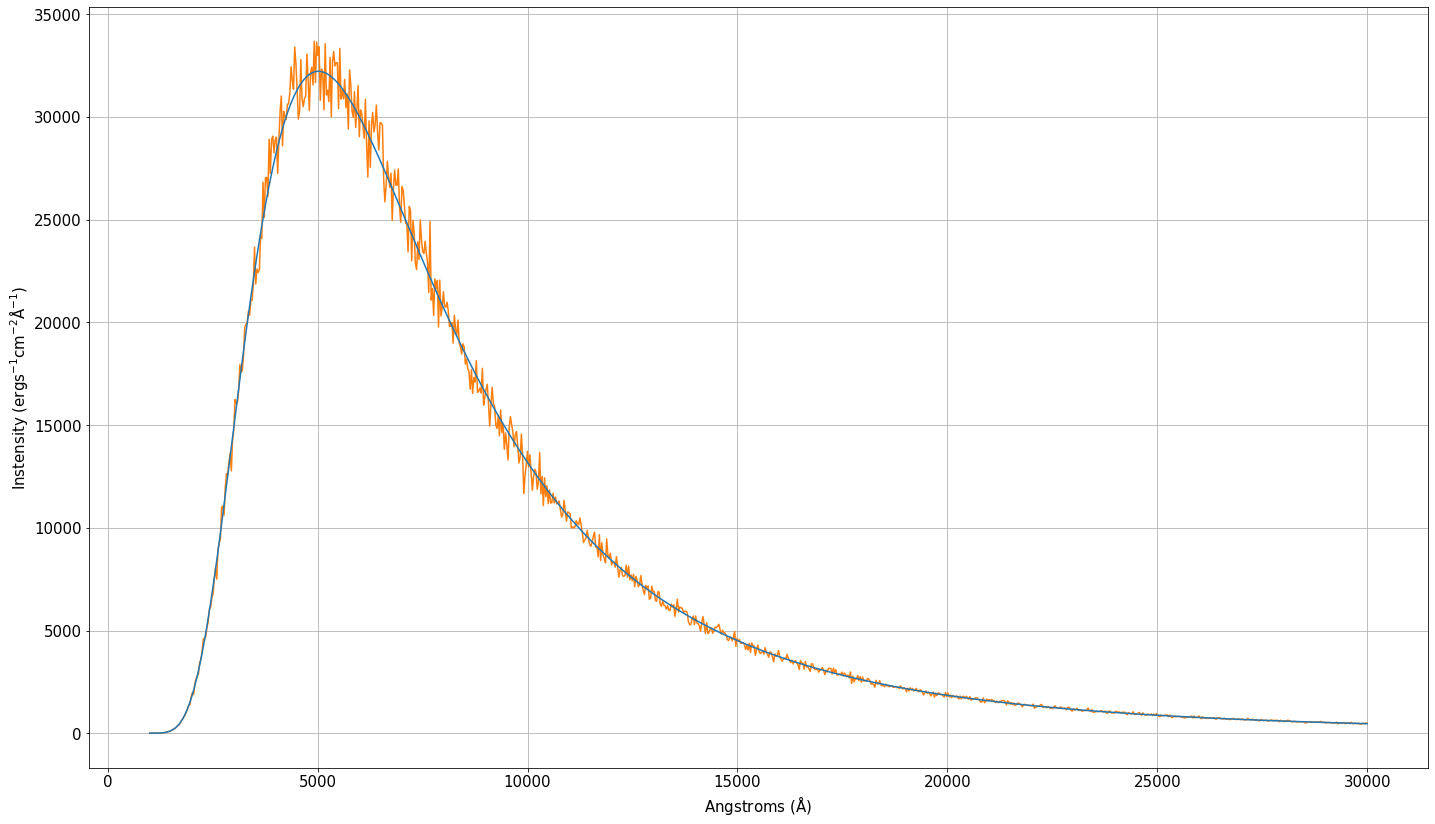

In [205]:
# Blackbody parameters
N = 1000
wavelengths = np.linspace(1000,30000,N)
temp = 5773
z = 3 
snr = 25 # signal to noise ratio

# Create the blackbody curve and plot
true_blackbody = blackbody(wavelengths,temp,z)
noise_blackbody = true_blackbody * np.random.randn(N)/snr
obs_blackbody = true_blackbody + noise_blackbody

plt.figure(figsize=[24,14])
plt.plot(wavelengths,obs_blackbody,c='tab:orange')
plt.plot(wavelengths,true_blackbody)
plt.xlabel(r'Angstroms ($\rm \AA$)')
plt.ylabel(r'Instensity ($\rm erg s^{-1} cm^{-2} \AA^{-1} $)')
plt.grid()
plt.show()

### Q1. What would the log likelihood function look like?

In [176]:
def lnl_blkbdy(theta,x,y,yerr):
    teff, red = theta
    model = blackbody(wavelengths,teff,red)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

### Q2. What would be good initial guesses for the star's $T_0$ and $z$ according to MLE?

Unlike the example above add on a random number to both of the true values. For the temperature use a number between 0 and 16 and for the redshift a number between 0 and 1.

In [177]:
b_cgs = b_wien.to(u.AA*u.K).value # converting Wien's displacement law constant to more appropriate units

# np.random.seed(42)
nll = lambda *args: -lnl_blkbdy(*args)
initial = np.array([temp + 100.*np.random.rand(), z + np.random.rand()])
soln = minimize(nll, initial, args=(wavelengths, obs_blackbody, noise_blackbody))
temp_ml, z_ml = soln.x

temp_ml,z_ml

(5772.733464201023, 2.99984055866267)

### Q3. What would a log prior look like?

In [178]:
def lnprior_blkbdy(theta):
    teff, red = theta
    if 4000.0 < teff < 7500 and 0.0 < red < 10.0:
        return 0.0
    return -np.inf

### Q4. What do the final distributions for the values of the temperature and redshift (make a corner plot)? What values do you get for the temperature and redsift?

Code up the log probability function:

In [179]:
def lnprobability_blackbody(theta, x, y, yerr):
    lp = lnprior_blkbdy(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnl_blkbdy(theta, x, y, yerr)

Run an MCMC:

In [180]:
# intial positions of walkers for all three parameters
pos = soln.x + 1e-4 * np.random.randn(50, 2) 
nwalkers, ndim = pos.shape

# sample the distribution an marginalize
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnprobability_blackbody, args=(wavelengths, obs_blackbody, noise_blackbody)
)
sampler.run_mcmc(pos, 5000, progress=True); # run for 5000 steps

100%|██████████| 5000/5000 [03:06<00:00, 26.86it/s]


Plot the position chains:

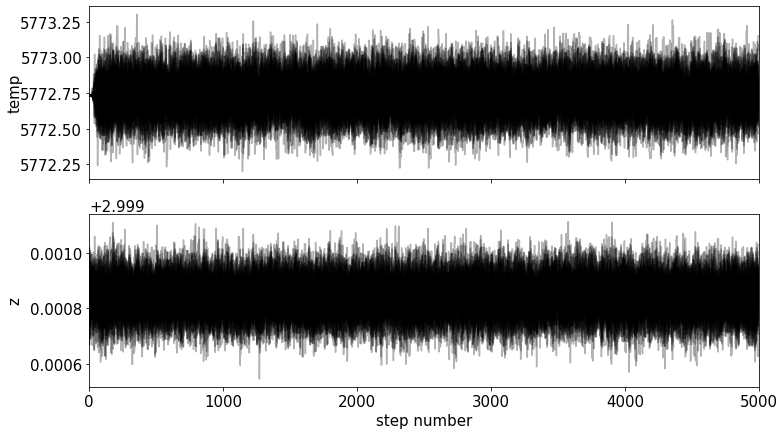

In [181]:
fig, axes = plt.subplots(2, figsize=(12, 7), sharex=True)
samples = sampler.get_chain()
labels = ["temp", "z"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Find the auto correlation time and create the flat distributions 

In [182]:
tau = sampler.get_autocorr_time()
print(tau)

[31.79910055 29.79459098]


In [183]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(16300, 2)


Plot the corner plot

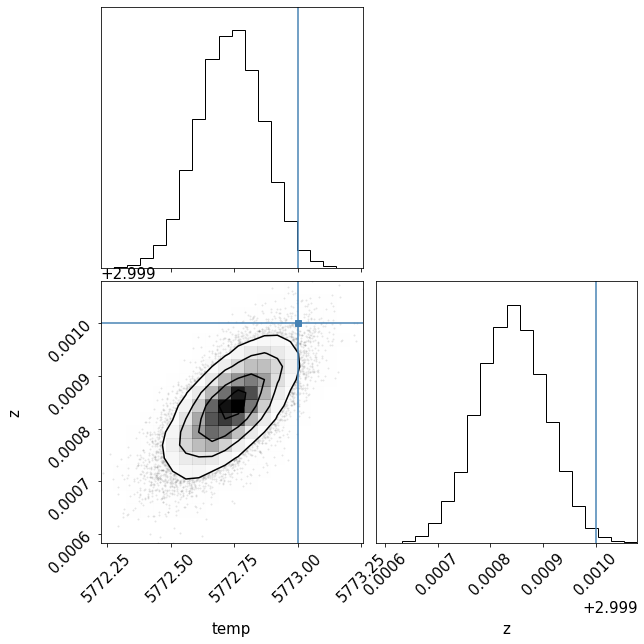

In [204]:
corner.corner(flat_samples, labels=labels, truths=[temp, z], smooth=0.5, fig=plt.figure(figsize=[10,10]));

Print the fitted values and plot the observed blackbody with the fitted blackbody and make a second plot of the residuals. When getting the fitted blackbody curve you can use np.mean(flat_samples[:, 0]) for the temperature and np.mean(flat_samples[:, 1]) for the redshift.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

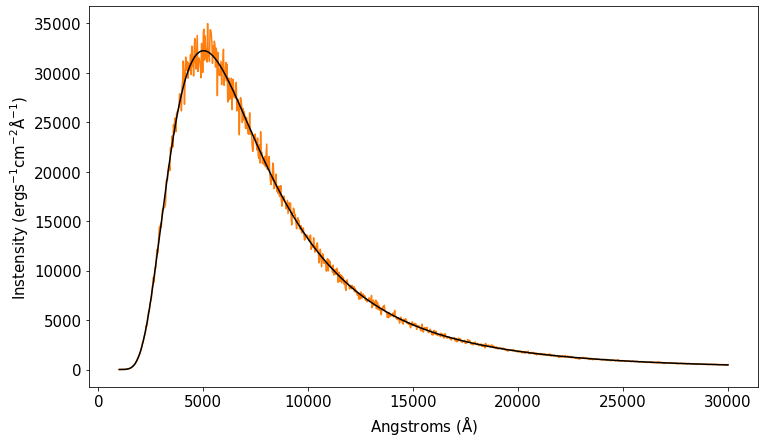

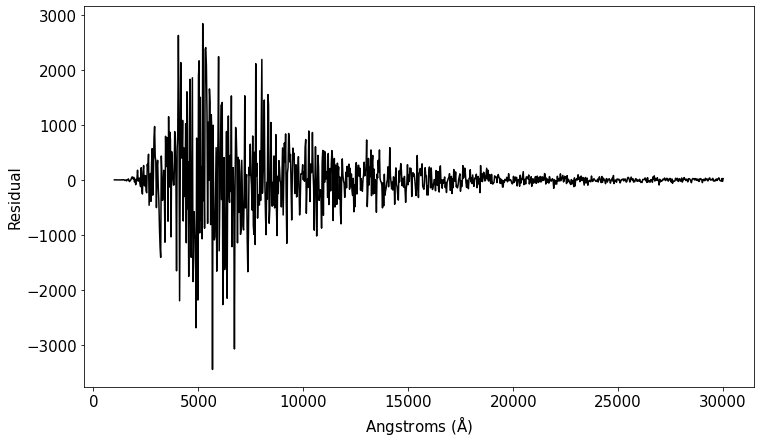

In [201]:
# print the fitted parameters
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
fit_blackbody = blackbody(wavelengths,np.mean(flat_samples[:, 0]),np.mean(flat_samples[:, 1]))
    
# Plot the MCMC results
plt.figure(figsize=[12,7])
plt.plot(wavelengths, obs_blackbody, c='tab:orange')
plt.plot(wavelengths, fit_blackbody, "k", label="truth")
plt.xlabel(r'Angstroms ($\rm \AA$)')
plt.ylabel(r'Instensity ($\rm erg s^{-1} cm^{-2} \AA^{-1} $)');

# Plot the residuals
plt.figure(figsize=[12,7])
plt.plot(wavelengths, obs_blackbody-fit_blackbody, "k", label="truth")
plt.xlabel(r'Angstroms ($\rm \AA$)')
plt.ylabel(r'Residual');